In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
import os
import numpy as np
import cv2 as cv
import torch
from google.colab.patches import cv2_imshow


In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(724, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']         

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(724, activation="relu")(latent_inputs)
x = layers.Dense(16384, activation="relu")(x)
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 724)               23892     
                                                                 
 dense_2 (Dense)             (None, 16384)             11878400  
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      295040    
 ranspose)                                                 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
dir_path = "/content/gdrive/MyDrive/guided-diffusion/datasets/IITD_LQ_128/Data"

In [ ]:
shape = (128, 128, 1)
images = []
for i in os.listdir(dir_path):
  if(i[-3:]=='png'):
    image_path = os.path.join(dir_path, i)
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # image = image[:, :, np.newaxis]
    # print(type(image), np.shape(image))
    images.append(image)
images=np.array(images)

In [ ]:
np.shape(images)

(964, 128, 128)

In [ ]:
images = np.expand_dims(images, -1).astype("float32") / 255

In [ ]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# images = np.expand_dims(images, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(images, epochs=300, batch_size=128)

Epoch 1/300
8/8 [==============================] - 23s 378ms/step - loss: 11576.1982 - reconstruction_loss: 11539.7383 - kl_loss: 42.8087
Epoch 2/300
8/8 [==============================] - 1s 143ms/step - loss: 11335.6099 - reconstruction_loss: 11340.4951 - kl_loss: 0.0113
Epoch 3/300
8/8 [==============================] - 1s 143ms/step - loss: 11343.3001 - reconstruction_loss: 11341.0117 - kl_loss: 0.0048
Epoch 4/300
8/8 [==============================] - 1s 144ms/step - loss: 11321.5788 - reconstruction_loss: 11312.5098 - kl_loss: 0.0488
Epoch 5/300
8/8 [==============================] - 1s 154ms/step - loss: 11199.3698 - reconstruction_loss: 11128.3076 - kl_loss: 0.9064
Epoch 6/300
8/8 [==============================] - 1s 158ms/step - loss: 10853.2120 - reconstruction_loss: 10823.1523 - kl_loss: 3.7909
Epoch 7/300
8/8 [==============================] - 1s 162ms/step - loss: 10724.8673 - reconstruction_loss: 10714.3799 - kl_loss: 0.3438
Epoch 8/300
8/8 [=============================

In [ ]:
digit_size = 128
num_samples = 100
images=[]

for _ in range(num_samples):
    temp=((np.random.rand(latent_dim)*2)-1).tolist()
    z_sample=np.array([temp])
    x_decoded = (vae.decoder.predict(z_sample))*255
    images.append(x_decoded[0].reshape(digit_size, digit_size))

1/1 [==============================] - 0s 22ms/step


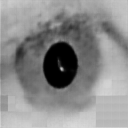

In [ ]:
cv2_imshow(images[0])

In [ ]:
save_dir = "/content/gdrive/MyDrive/guided-diffusion/datasets/IITD_LQ_128/VAE_images"
for i in range(len(images)):
  path = os.path.join(save_dir, str(i))
  path += ".png"
  cv.imwrite(path, images[i])
